### Introduction to Basic Tracking
Local fiber tracking is an approach used to model white matter fibers by creating streamlines from local directional information.

In order to perform local fiber tracking, three things are needed: 
1. A method for getting directinos from a diffusion datast
2. A method for identifyin when the tracking must stop
3. A set of seeds from which to begin tracking.

In [2]:
%%bash
ls /Users/u4307082/Desktop/neuro_tutorials/nipype_tutorial-master/data/dipy_tutorial/sub-01_dipy/dwi/sub-01_ses-test_dwi.nii.gz

In [3]:
fdwi = ('~/Desktop/neuro_tutorials/nipype_tutorial-master/data/dipy_tutorial/sub-01_dipy/dwi/sub-01_ses-test_dwi.nii.gz')
fbval = ('~/Desktop/neuro_tutorials/nipype_tutorial-master/data/dipy_tutorial/sub-01_dipy/dwi.bval')
fbvec = ('~/Desktop/neuro_tutorials/nipype_tutorial-master/data/dipy_tutorial/sub-01_dipy/dwi.bvec')
wm_mask = ('~/Desktop/neuro_tutorials/nipype_tutorial-master/data/dipy_tutorial/sub-01_dipy/anat/sub-01_ses-test_brain_WM.nii.gz')

To follow the tutorial we need a white matter mask of the brain. We can get one of these using FSL-BET and then FSL-FAST.

In [4]:
%%bash
bet ./anat/sub-01_ses-test_T1w.nii.gz ./anat/sub-01_ses-test_BRAIN -m

In [5]:
%%bash
fslfast -b ./anat/sub-01_ses-test_BRAIN.nii.gz

After a bit of manual editing we can make a white matter mask that is binary and has the value of 0 for no value and 1 for wm.

Let's start by first loading our dMRI datasets. For this we will need a python library called nibabel which enables us t0 read and write neuroimaging specific file formats.

In [6]:
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)

So from this above command we create 'data' which is a 4D array, with the first 3 dimensions being the i, j and k voxel coordinates and the last demension being the number of non-seighted (S0s) and diffusion weighted volumes. We can check this using the following code.

In [7]:
print(data.shape)

(128, 128, 72, 71)


The next step is to load the b-values and b-vectors from the disk using the function read_bvals_bvecs.

In [8]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In DIPY, we can use an object called GradientTable which holds all the acquisition specific parameters e.g. b-values, b-vectors, timings and others.

In [9]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [10]:
# Enables/disables interactive visualization
interactive = False

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

The first thing we need to do here is find a way of getting our directions from our diffusion dataset. In order to do that, we can fit the data to a Constant Solid Angle ODF Model. This estimates the Orientation Distribution Function (ODF) at each voxel. The ODF is the distribution of water as a function of direction. The peaks of an ODF are good estimates for the orientation of tract segments at a point in the image. Here we will use 'peaks_from_model' to fit the data and calculate the fiber directions in all voxels of white matter.

We have converted our WM mask to the right resolution, and it is a binary mask now, so there is a 1 where there is WM and a 0 everywhere else. We now need to figure out a way that we can convert that 3D nifti image to a numpy array

In [11]:
import numpy as np
import nibabel as nib

In [12]:
img = nib.load('./sub-01_ses-test_brain_WM_lowres.nii.gz')

In [13]:
a = np.array(img.dataobj)

In [14]:
white_matter = np.array(a, dtype=bool)

In [15]:
white_matter

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [16]:
from dipy.reconst.csdeconv import auto_response
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

response, ratio = auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

In [33]:
%%bash
conda install -c conda-forge fury

For quality assurance we can also visualise a slice from the direction field which we will use as the basis to perform the tracking. The visualisation will be done using the fury python package.

In [17]:
from dipy.viz import window, actor, has_fury

if has_fury:
    ren = window.Scene()
    ren.add(actor.peak_slicer(csa_peaks.peak_dirs,
                              csa_peaks.peak_values,
                              colors=None))

    window.record(ren, out_path='csa_direction_field.png', size=(900, 900))

    if interactive:
        window.show(ren, size=(800, 800))

/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


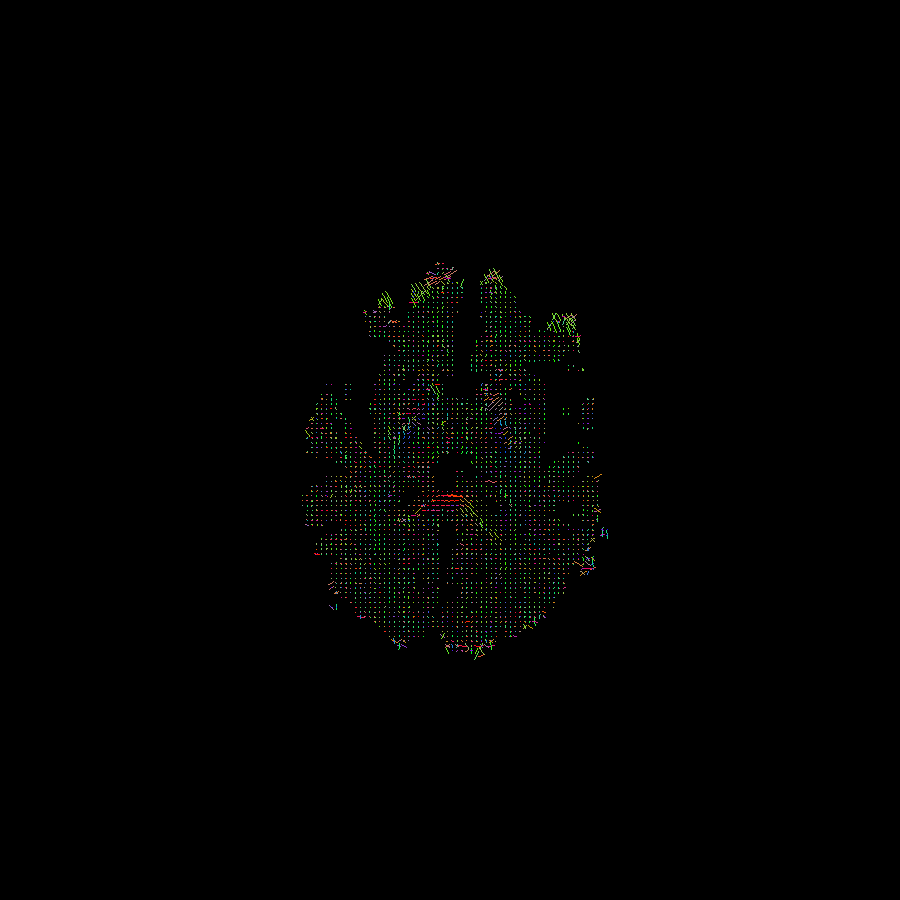

Now we need a method of restricting fiber tracking to areas with good directionality information. We have a white matter mask, but we also need to restrict it to areas where the ODF shows significant restricted diffusion by thresholding on the generalized fractional anisotropy (GFA).

In [18]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, 0.25)

Again, for quality assurance we can also visualize a slice of the GFA and resulting tracking mask.

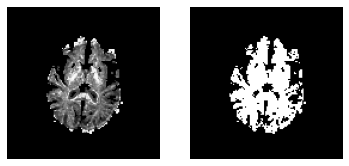

In [19]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:,:,sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

While it looks like our white matter masks actually encompassed much of the thalamus too, which should have been removed, we have on the left the begginings of a tracking mask derived from generalized fractional anisotropy.

Before we can begin tracking we need to specify where to seed this process. Generally the seeds are chosen depending on the pathways that we are interested in modelling. For this example we will look at a 2 x 2 x 2 grid of seeds per voxel in a sagittal slice of the corpus callosum giving us a nice model of some of the fibres that traverse that structure.

We had to do a bit of work here as we needed a bit of work here as we need a mask of the corpus callosum where we can seed our pathways. As we don't have one yet for this data, we need to make one. The way we can do this is through freesurfer.

In [1]:
%%bash
freesurfer recon-all -sub_01 -all

After this we can look at the mri/aseg.mgz file which has all of the segmented structures. Freesurfer segments the corpus callosum into 5 sub-sections. These are labelled 251-255 in the aseg file. We can extract these particular sections from the file and save them using mri_binarize.

In [2]:
%%
mri_binarize --i aseg.mgz --o cc_mask.mgz --min 251 --max 255

Now we can convert this to a nifti file using mri_convert.

In [3]:
%%bash
mri_convert ./cc_mask.mgz ./cc_mask.nii.gz

Next we convert our freesurfer T1 to the same format as our structural T1 image.

In [4]:
%%bash
mri_convert anat/sub-01/mri/T1.mgz ./T1_struc.nii.gz

The next thing we needed to do was convert the freesurfer T1 to our nifti image space.

In [5]:
%%bash
flirt -in T1_struc.nii.gz -ref anat/sub-01_ses-test_T1w.nii.gz -out T1_fsl_rego.nii.gz -omat T1_fsl_rego.mat

In [6]:
%%bash
flirt -in ./cc_mask.nii.gz -ref ./anat/sub-01_ses-test_brain_WM.nii.gz -init ./T1_fsl_rego.mat -out ./cc_highres.nii.gz -applyxfm ;

I am sure ive made too many moves here, but I can't think of a better way, so now I will repeat this process but finding a transformation matrix that can move our cc_mask from highres to lowres (dwi) space.

The first thing we do is make a transformation matrix. We should use the structural image with the most contrast for this process.

In [ ]:
%%bash
flirt -in ./sub-01_ses-test_T1w.nii.gz -ref sub-01_ses-test_dwi.nii.gz -out t1_dwi_rego -omat t1_to_dwi

Now we have our transformation matrices we can convert out cc mask from T1 space to DWI space.

In [1]:
%%
flirt -in ./cc_highres.nii.gz -ref sub-01_ses-test_dwi.nii.gz -init t1_to_dwi.mat -out cc_lowres_dwi -applyxfm

Now we can repeat the steps above to create a numpy array where with True values for places in the image where we want to seed our tracking from.

In [20]:
img2 = nib.load('./dwi/cc_lowres_dwi.nii.gz')

In [21]:
b = np.array(img2.dataobj)

In [24]:
callosum_mask = np.array(b, dtype=bool)

In [25]:
callosum_mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [26]:
from dipy.tracking import utils
seeds = utils.seeds_from_mask(callosum_mask, affine, density=[2, 2, 2])

Finally we bring it all together using LocalTracking, performed using the EuDX algorithm. EuDX is a fast algorithm that we se to generate streamlines. This algorithm is what is used here and the default option when providing the output of peaks directly in LocalTracking.

In [27]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

We will now display the resulting streamlines using the fury package.

In [29]:
from dipy.viz import colormap

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    r = window.Renderer()
    r.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(r, out_path='tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(r)

/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/fury/utils.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)
/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
  # This is added back by InteractiveShellApp.init_path()


ahaha clearly we have some work to do as the image below does not resemble anything close to what we would be expecting. None-the-less, it is a first start and I am pretty proud of it.

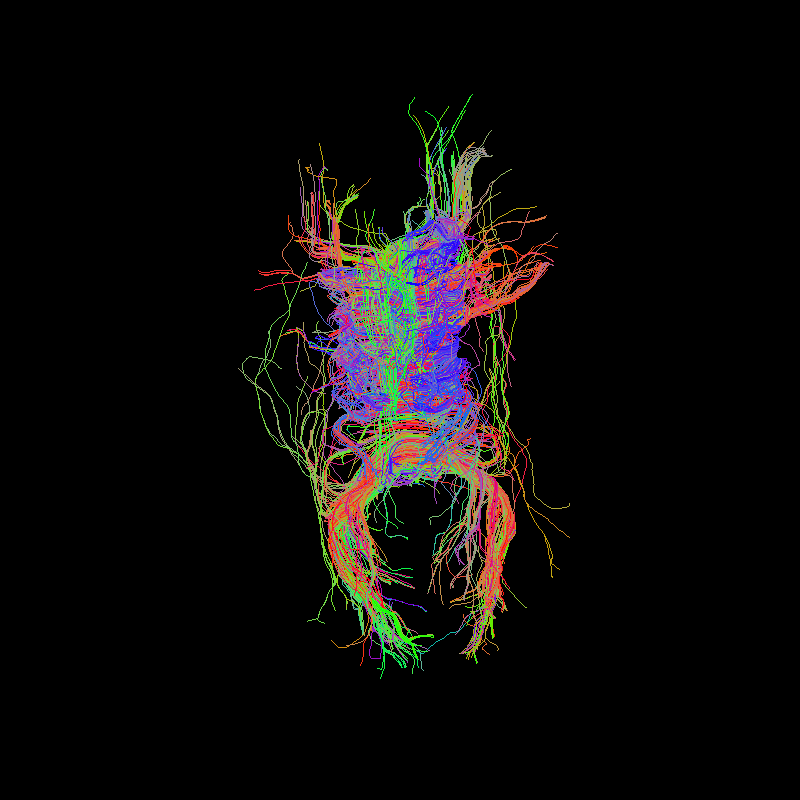

We have now created a deterministic set of streamlines using the EuDX algorithm. This is so called deterministic because if you repeat the fiber tracking (with all the inputs the same) we would produce the exact same results. We can save these streamlines as a Trackvis file so it can be loaded into other software for visualization or further analysis.

In [32]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

sft = StatefulTractogram(streamlines, fdwi, Space.RASMM)
save_trk(sft, "tractogram_EuDX.trk", streamlines)